In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available.")

/home/apakiman/anaconda3/envs/TF-keras/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-23 13:50:40.298320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 13:50:40.342745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 13:50:40.345788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 13:50:41.113806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPUs available.


2023-08-23 13:50:41.893052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 13:50:41.894160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
(dataset_train_original, dataset_validate_original), infor = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[90%:]"], # pretending we don't have a big dataset
                                          # dataset is already shuffled
    as_supervised=True,
    with_info=True
)

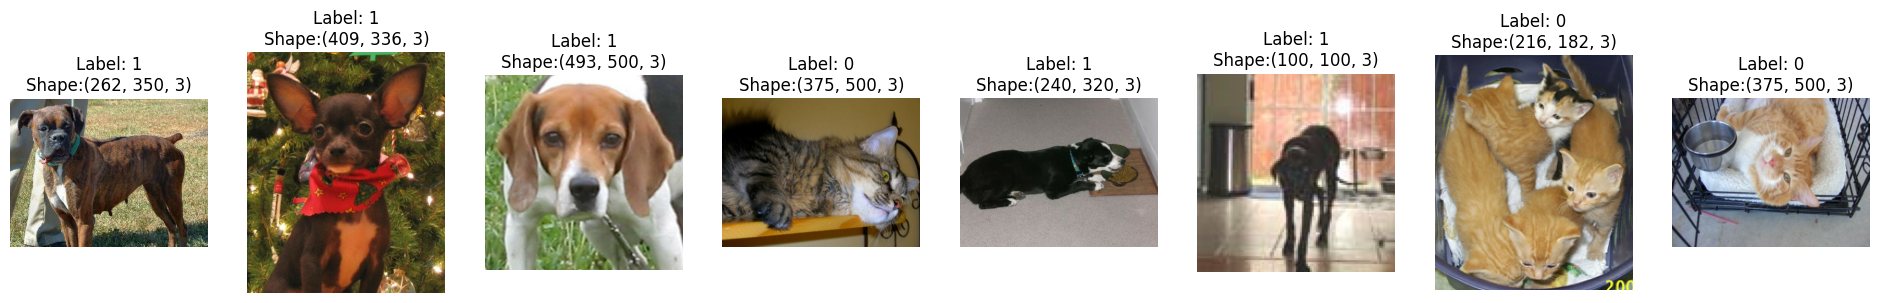

In [50]:
num_samples=8
index=1
plt.figure(figsize=(24,4))
for image, label in dataset_train_original.take(num_samples):
    plt.subplot(1, num_samples, index)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f'Label: {label}\nShape:{image.shape}')
    index+=1

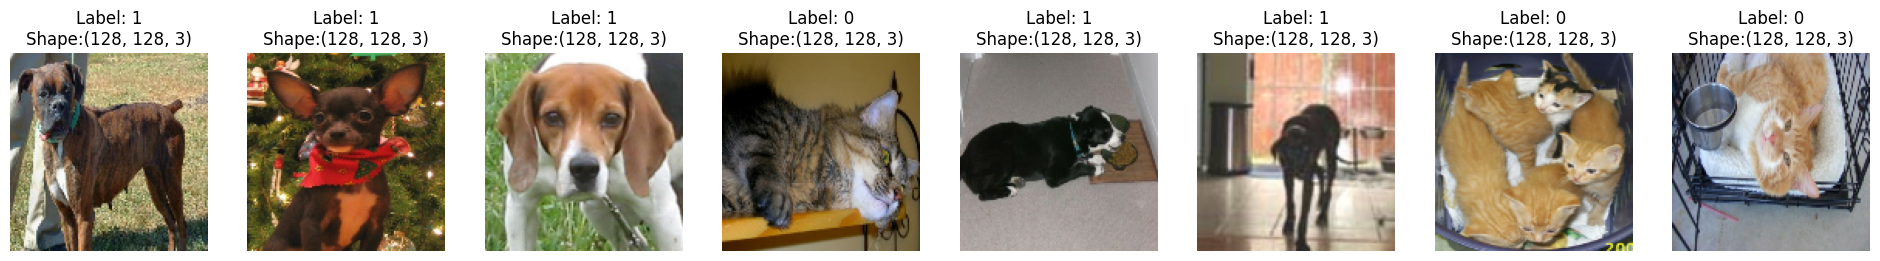

In [11]:
def encode(image, label, image_size=(128, 128)):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    return image, label
dataset = dataset_train_original.map(lambda image, label: encode(image, label))

num_samples=8
index=1
plt.figure(figsize=(24,4))
for image, label in dataset.take(num_samples):
    plt.subplot(1, num_samples, index)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f'Label: {label}\nShape:{image.shape}')
    index+=1

In [12]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [13]:
history_list = {}
epochs = 50

In [14]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

# Train a CNN from scratch

In [55]:
model =models.Sequential([
    layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 16, 64)       

In [56]:
3 * 3 * 32 * 3 + 32  # kernel * kernel * filter * 3rd deimention + biases=filter

896

- first layer go from (3, 3, 3) (kernel, kernel, 3rd deimention), that is 27 input to learn the filter that has 32 nodes, so the output of one kernel is (1, 1, 32)

- making image size smaller, the number of parameters remain the same but the output size differ.

In [57]:
model.compile(
    optimizer ='adam',
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

In [58]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate,
)

history_list["baseline"] = history.history
render_history(history.history)

Epoch 1/50


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


19/19 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5219

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


19/19 [==============================] - 19s 898ms/step - loss: 0.6913 - accuracy: 0.5219 - val_loss: 0.7160 - val_accuracy: 0.4987
Epoch 2/50
 5/19 [======>.......................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5375 

KeyboardInterrupt: 

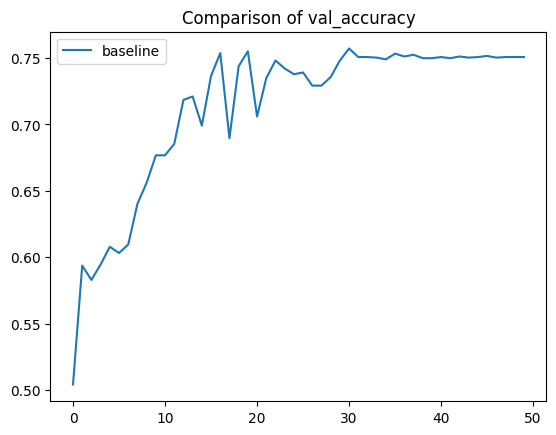

In [ ]:
compare_histories()

In [ ]:
model.evaluate(dataset_validate)

19/19 [==============================] - 3s 166ms/step - loss: 1.8090 - accuracy: 0.7506


[1.8090461492538452, 0.750644862651825]

In [23]:
from tensorflow import keras
import kerastuner as kt

def build_model(hp):
    f = hp.Int(name="f", min_value=64, max_value=112, step=16)    # start size
    # n = hp.Int(name="n", min_value=1, max_value=2, step=1)    # number of reapet
    # m = hp.Int(name="m", min_value=3, max_value=5, step=1)    # number of unit repeat
    k = hp.Int(name="k", min_value=3, max_value=5, step=2)    # kernel size
    d = hp.Int(name="d", min_value=32, max_value=128, step=32)    # dense layer size
    p = hp.Int(name="p", min_value=2, max_value=5, step=2)    # max pooling

    n, m = 2, 5
    # f, k, d, p = 

    unit = [
        layers.Conv2D(f, (k,k), padding="same", activation="relu"),
        layers.MaxPooling2D(p,p),
    ]

    unit_list = []
    for mi in range(m):
        for ni in range(n):
            unit_list+= unit

    model = keras.Sequential(
        unit_list + [
            layers.Flatten(),
            layers.Dense(d, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    
    model.compile(
        optimizer ='adam',
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    return model

In [24]:

tuner = kt.BayesianOptimization(
    build_model, #hypermodel
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyper_tuning",
    overwrite=True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
f (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 112, 'step': 16, 'sampling': 'linear'}
k (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 2, 'sampling': 'linear'}
d (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
p (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 2, 'sampling': 'linear'}


In [25]:
# make hyper parameter study
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    dataset_train,
    epochs=5,
    validation_data=dataset_validate,
    callbacks=callbacks,
    verbose=2,
)

Trial 3 Complete [00h 02m 24s]
val_accuracy: 0.6988392174243927

Best val_accuracy So Far: 0.6988392174243927
Total elapsed time: 00h 14m 28s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [21]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)

# Print the best hyperparameters in a readable format
for bi in best_hps:
  for param, value in bi.values.items():
      print(f"{param}: {value}")

f: 80
k: 3
d: 64
f: 80
k: 5
d: 32
f: 96
k: 5
d: 96


In [ ]:
model =models.Sequential([
    layers.Conv2D(80, (3,3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.summary()